In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
data = pd.read_csv('./compression-data.csv', sep=';')

In [49]:
data = data.sort_values('cells')
#data = data[data['cells'] > 0]
fulldata = data
data

,cells,bytes,build_duration_nanosec,build_duration_total_nanosec,retr_duration_avg_nanosec,algorithm,table
573,879808,41943040,53078665,3559459959,369,baseline,mate_main_tokenized
562,2691359,8035064,358139014,10428638346,371,dedup_btree,main_tokenized_embedding
554,2953720,6132768,433504598,12635191276,254,ns,main_tokenized
346,3783376,167772160,227562142,4315840231,399,baseline,mate_main_tokenized
345,7571860,335544320,460222511,4998556189,419,baseline,mate_main_tokenized
...,...,...,...,...,...,...,...
140,1586433715,24421548544,207376438643,387208357651,1009,ns,gittables_main_tokenized
85,1586435541,42154694344,155635782300,591700168404,16696,dedup_btree,gittables_main_tokenized
167,1588021298,24430942472,207878096790,398862161376,982,ns,gittables_main_tokenized
139,1588021298,39465052304,147221973909,467141792557,814,dedup_hash,gittables_main_tokenized


In [50]:
c = {
    'ns': 'red',
    'baseline': 'blue',
    'dedup_hash': 'orange',
    'dedup_btree': 'violet',
}   


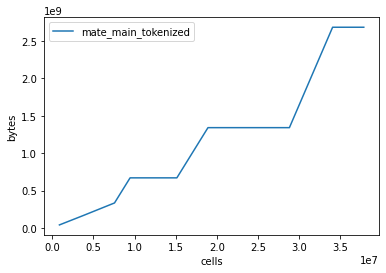

In [51]:
fig, ax = plt.subplots()
for t, row in data[data['algorithm'] == 'baseline'].groupby("table"):
    ax.plot("cells", "bytes", data=row, label=t)

ax.set_xlabel("cells")
ax.set_ylabel("bytes")
ax.legend()

Text(0.5, 1.0, 'index duration per collection')

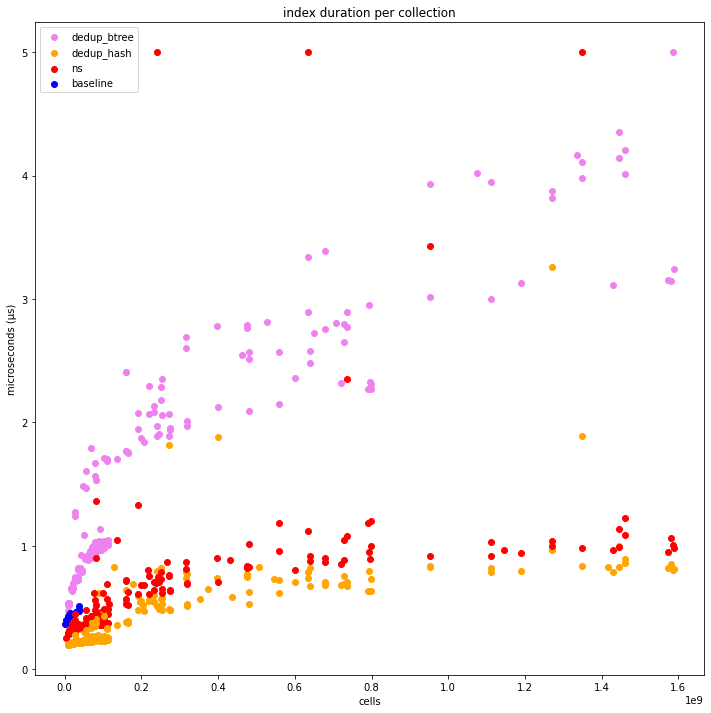

In [52]:

fig, ax = plt.subplots(figsize=(12, 12))

data['retr_duration_avg_microsec'] = data['retr_duration_avg_nanosec'] / 1000

data['retr_duration_avg_microsec_capped'] = np.array([min(5.0, elem) for elem in data['retr_duration_avg_microsec']])

done = set()
for [table,algo], row in data.groupby(["table", "algorithm"]):
    p = ax.scatter('cells', 'retr_duration_avg_microsec_capped', c=c[algo], data=row, label="")

    if not algo in done:
        done.add(algo)
        p.set_label(algo)


ax.legend()
ax.set_ylabel('microseconds (μs)')
ax.set_xlabel('cells')
ax.set_title("index duration per collection")



In [53]:
from math import sqrt


def pad(data, offset):
    data = np.insert(data, 0, np.ones(offset)*data[0])
    data = np.append(data, np.ones(offset)*data[-1])
    return data

def normalize(data):
    return data / sqrt(sum(data*data))

def apply_kernel(data, kernel):
    if len(kernel) % 2 != 1:
        raise "Kernel must have uneven amount of entries"

    kernel = normalize(np.array(kernel))

    # length of data without offset
    l = len(data)
    offset = (len(kernel)-1) >> 1

    data = pad(np.array(data), offset)

    slice = data[:l] * kernel[0]
    for i in range(1, len(kernel)):
        weight = kernel[i]
        end = i + l
        slice += data[i:end]

    return slice

smooth = lambda data: apply_kernel(data, [0.25, 0.75, 0.25])

In [54]:
pad([1, 2, 3], 2)

array([1., 1., 1., 2., 3., 3., 3.])

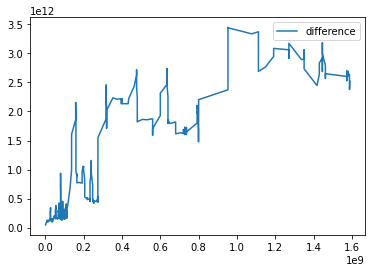

In [55]:
fig, ax = plt.subplots()
tt = "build_duration_total_nanosec"
raw = "build_duration_nanosec"
# ax.plot("cells", raw, data=data, label="precise")
# ax.plot("cells", tt, data=data, label="total")
ax.plot(data["cells"], apply_kernel(data[tt] - data[raw], np.ones(9)), label="difference")
ax.legend()

## TODO 

- investigate relation between cardinality and access time
- investigate relation between cardinality and difference in compression (baseline vs dedup)

Text(0.5, 1.0, 'build time per algorithm')

<Figure size 432x288 with 0 Axes>

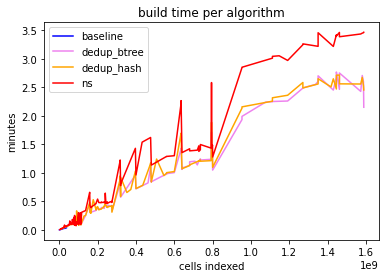

In [56]:
plt.figure(figsize=(6, 4))
fig, bta = plt.subplots()

data["build_duration_sec"] = data["build_duration_nanosec"] * 1e-9
data["build_duration_min"] = data["build_duration_sec"] / 60

for algo,row in data.groupby("algorithm"):
    p, = bta.plot('cells', 'build_duration_min', c=c[algo], data=row)
    p.set_label(algo)


bta.set_xlabel('cells indexed')
bta.set_ylabel('minutes')
bta.legend()
bta.set_title("build time per algorithm")

Text(0.5, 1.0, 'memory per table')

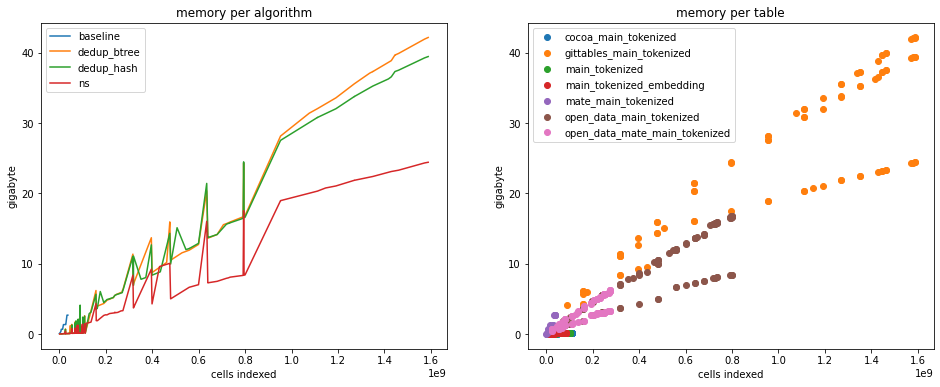

In [57]:
data['gigabyte'] = data['bytes'] / 1e9

fig,[mpa, mpt] = plt.subplots(1, 2, figsize=(16, 6))
for algo,row in data.groupby("algorithm"):
    p, = mpa.plot('cells', 'gigabyte',data=row)
    p.set_label(algo)
    # mpt.scatter('cells', 'gigabyte', data=row, label="")

mpa.set_xlabel('cells indexed')
mpa.set_ylabel('gigabyte')
mpa.legend()
mpa.set_title("memory per algorithm")

# now per table
#fig,mpt = plt.subplots(figsize=(16, 6))
for table,row in data.groupby("table"):
    p = mpt.scatter('cells', 'gigabyte', data=row)
    p.set_label(table)

mpt.set_xlabel('cells indexed')
mpt.set_ylabel('gigabyte')
mpt.legend()
mpt.set_title("memory per table")

the memory footprint is not dependant on the dataset at hand, but rather the amount of data consumed and the algorithm presented